In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
from tqdm import tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

In [5]:
gwps_mean_pop = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240311_fibroblast_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])

Loading matrix...
Loading metadata...
Done in 2.1829025745391846s.
Done.


In [6]:
gwps_mean_pop.genes.index.name = 'gene_id'

# Annotating masked_active and expanded_masked_active guides, plus picking strongest representatives when multiple guides target same gene

In [7]:
expanded_guides = pd.read_csv('/data/norman/southark/tfs_standardized/20240319_rescued_fibroblast_guides.csv', index_col=0)
gwps_mean_pop.cells['expanded_masked_active'] = expanded_guides['expanded_masked_active']

In [9]:
guide_library = pd.read_csv('/data/norman/southark/tfs_standardized/20240318_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef.csv', index_col=0)

In [10]:
guide_library['masked_active'] = gwps_mean_pop.cells['masked_active']
guide_library['expanded_masked_active'] = gwps_mean_pop.cells['expanded_masked_active']
guide_library['masked_active'].fillna(False, inplace=True)
guide_library['expanded_masked_active'].fillna(False, inplace=True)

In [11]:
guide_library['de_genes'] = gwps_mean_pop.cells['de_genes']

In [12]:
masked_and_strongest = guide_library.query('masked_active and not bad_seed').sort_values('de_genes', ascending=False).groupby('target_gene').head(1).index

In [13]:
expanded_masked = guide_library.query('expanded_masked_active and not bad_seed').index

In [14]:
gwps_mean_pop.cells['primary_guide'] = gwps_mean_pop.cells.index.isin(masked_and_strongest)
gwps_mean_pop.cells['expanded_primary_guide'] = gwps_mean_pop.cells.index.isin(np.union1d(masked_and_strongest, expanded_masked))

# Feature selection for use in embedding

In [1]:
# take genes that were put into programs by sparse PCA procedure

In [15]:
comps = pd.read_csv('20240331_fibroblast_bulk_comps.csv', index_col=0)
target_genes = comps.loc[:, (comps>0).any()].columns
target_gene_ids = gwps_mean_pop.genes.query('gene_name in @target_genes').index

In [50]:
masked_active_genes = gwps_mean_pop.cells.query('masked_active')['target_gene'].unique()

In [51]:
gwps_expr = gwps_mean_pop.where(cells='de_genes > 10 and target_gene not in @masked_active_genes',
                                genes=target_gene_ids, masked_active_genes=masked_active_genes)

In [53]:
gwps_expr['gene_id'] = guide_library.reindex(gwps_expr.index)['gene_name']
gwps_expr.set_index('gene_id', append=True, inplace=True)

In [66]:
masked_gwps_expr = get_masked_expr(gwps_expr)
masked_gwps_variable_expr = get_masked_expr(gwps_expr[target_gene_ids])

100%|█████████████████████████████████████████| 138/138 [00:00<00:00, 4515.49it/s]


In [67]:
# gwps_expr[gwps_variable_genes].to_csv('/scratch/tmn/genomewide_perturbseq/final/embedding_expression.csv')

In [68]:
%%time
gwps_corrs = masked_gwps_expr.T.corr()
gwps_variable_corrs = masked_gwps_variable_expr.T.corr()

CPU times: user 1min 34s, sys: 83.5 ms, total: 1min 34s
Wall time: 1min 34s


In [69]:
gwps_distances = 1 - gwps_corrs
gwps_variable_distances = 1 - gwps_variable_corrs

In [70]:
import pymde
import torch
from sklearn.manifold import SpectralEmbedding

# very mildly modified version of pymde's preserve_neighbors that uses sklearn's spectral 
# embedding as initialization instead of theirs. Their version appears to be non-deterministic
# at least on our server

def my_preserve_neighbors(
    data,
    embedding_dim=2,
    attractive_penalty=pymde.penalties.Log1p,
    repulsive_penalty=pymde.penalties.Log,
    constraint=None,
    n_neighbors=None,
    repulsive_fraction=None,
    max_distance=None,
    init="quadratic",
    device="cpu",
    verbose=False,
):

    if isinstance(data, pymde.preprocess.graph.Graph):
        n = data.n_items
    elif data.shape[0] <= 1:
        raise ValueError("The data matrix must have at least two rows.")
    else:
        n = data.shape[0]

    if n_neighbors is None:
        # target included edges to be ~1% of total number of edges
        n_choose_2 = n * (n - 1) / 2
        n_neighbors = int(max(min(15, n_choose_2 * 0.01 / n), 5))
    if n_neighbors > n:
        pymde.problem.LOGGER.warning(
            (
                "Requested n_neighbors {0} > number of items {1}."
                " Setting n_neighbors to {2}"
            ).format(n_neighbors, n, n - 1)
        )
        n_neighbors = n - 1

    if constraint is None and repulsive_penalty is not None:
        constraint = pymde.constraints.Centered()
    elif constraint is None and repulsive_penalty is None:
        constraint = pymde.constraints.Standardized()

    if isinstance(data, pymde.preprocess.graph.Graph):
        # enforce a max distance, otherwise may very well run out of memory
        # when n_items is large
        if max_distance is None:
            max_distance = (3 * torch.quantile(data.distances, 0.75)).item()

    if verbose:
        pymde.problem.LOGGER.info(
            f"Computing {n_neighbors}-nearest neighbors, with "
            f"max_distance={max_distance}"
        )

    knn_graph = pymde.preprocess.generic.k_nearest_neighbors(
        data,
        k=n_neighbors,
        max_distance=max_distance,
        verbose=verbose,
    )
    edges = knn_graph.edges.to(device)
    weights = knn_graph.weights.to(device)

    if isinstance(constraint, pymde.constraints.Anchored):
        # remove anchor-anchor edges before generating intialization
        edges, weights = pymde.recipes._remove_anchor_anchor_edges(
            edges, weights, constraint.anchors
        )

    if init == "quadratic":
        if verbose:
            pymde.problem.LOGGER.info("Computing quadratic initialization.")
        init = SpectralEmbedding(n_components=embedding_dim,
                             affinity='nearest_neighbors',
                             n_neighbors=n_neighbors,
                             eigen_solver='arpack').fit_transform(data)
        X_init = torch.Tensor(init.copy()).to(device)
        # X_init = pymde.quadratic.spectral(
        #    n, embedding_dim, edges, weights, device=device
        #)
        if not isinstance(
            constraint, (pymde.constraints._Centered, pymde.constraints._Standardized)
        ):
            constraint.project_onto_constraint(X_init, inplace=True)
    elif init == "random":
        X_init = constraint.initialization(n, embedding_dim, device)
    else:
        raise ValueError(
            f"Unsupported value '{init}' for keyword argument `init`; "
            "the supported values are 'quadratic' and 'random'."
        )

    if repulsive_penalty is not None:
        if repulsive_fraction is None:
            if isinstance(constraint, pymde.constraints._Standardized):
                # standardization constraint already implicity spreads,
                # so use a lower replusion
                repulsive_fraction = 0.5
            else:
                repulsive_fraction = 1

        n_choose_2 = int(n * (n - 1) / 2)
        n_repulsive = int(repulsive_fraction * (edges.shape[0]))
        # cannot sample more edges than there are available
        n_repulsive = min(n_repulsive, n_choose_2 - edges.shape[0])

        negative_edges = pymde.preprocess.sample_edges(
            n, n_repulsive, exclude=edges
        ).to(device)

        negative_weights = -torch.ones(
            negative_edges.shape[0], dtype=X_init.dtype, device=device
        )

        if isinstance(constraint, pymde.constraints.Anchored):
            negative_edges, negative_weights = _remove_anchor_anchor_edges(
                negative_edges, negative_weights, constraint.anchors
            )

        edges = torch.cat([edges, negative_edges])
        weights = torch.cat([weights, negative_weights])

        f = pymde.penalties.PushAndPull(
            weights,
            attractive_penalty=attractive_penalty,
            repulsive_penalty=repulsive_penalty,
        )
    else:
        f = attractive_penalty(weights)

    pymde.seed(0)
    mde = pymde.problem.MDE(
        n_items=n,
        embedding_dim=embedding_dim,
        edges=edges,
        distortion_function=f,
        constraint=constraint,
        device=device,
    )
        
    mde._X_init = X_init

    # TODO cache the graph for subsequent calls / constructor for MDE from graph
    distances = mde.distances(mde._X_init)
    if (distances == 0).any():
        # pathological scenario in which at least two points overlap can yield
        # non-differentiable average distortion. perturb the initialization to
        # mitigate.
        mde._X_init += 1e-4 * torch.randn(
            mde._X_init.shape,
            device=mde._X_init.device,
            dtype=mde._X_init.dtype,
        )
    return mde

In [71]:
def get_pymde_embedding(expr, embedding_dim=10, n_neighbors=None, init='quadratic', repulsive_fraction=1, return_embedding=False, max_iter=1000, memory_size=10000, eps=1e-5, device='cuda'):
    norm_expr = expr.fillna(0).T.copy()
    norm_expr = (norm_expr - norm_expr.mean()).div(norm_expr.std()).T
    
    pymde.seed(0)
    mde = my_preserve_neighbors(
        norm_expr.values,
        embedding_dim=embedding_dim,
        n_neighbors=n_neighbors,
        verbose=True,
        repulsive_fraction=repulsive_fraction,
        device=device,
        init=init,
    )
    embedding = mde.embed(verbose=True, max_iter=max_iter, memory_size=memory_size, eps=eps)
    embedding_df = pd.DataFrame(np.array(embedding.cpu()), index=expr.index)
    if return_embedding:
        return embedding_df, embedding, mde
    else:
        return embedding_df

In [76]:
gwps_viz_variable_embedding = get_pymde_embedding(masked_gwps_variable_expr,
                                    embedding_dim=2,
                                    n_neighbors=7,
                                    repulsive_fraction=5,
                                    max_iter=1400,
                                    device='cpu',
                                    eps=1e-6,
                                    init='quadratic')

Apr 05 04:40:46 PM: Computing 7-nearest neighbors, with max_distance=None
Apr 05 04:40:46 PM: Exact nearest neighbors by brute force 
Apr 05 04:40:46 PM: Computing quadratic initialization.
Apr 05 04:40:48 PM: Fitting a centered embedding into R^2, for a graph with 3231 items and 123366 edges.
Apr 05 04:40:48 PM: `embed` method parameters: eps=1.0e-06, max_iter=1400, memory_size=10000
Apr 05 04:40:48 PM: iteration 0000 | distortion 4.259384 | residual norm 5.45565 | step length 0.00359957 | percent change 3.46974
Apr 05 04:40:50 PM: iteration 0140 | distortion 0.178549 | residual norm 0.000347013 | step length 1 | percent change 0.569646
Apr 05 04:40:52 PM: iteration 0280 | distortion 0.172018 | residual norm 0.0001594 | step length 1 | percent change 0.20062
Apr 05 04:40:55 PM: iteration 0420 | distortion 0.170711 | residual norm 6.30038e-05 | step length 1 | percent change 0.170707
Apr 05 04:40:59 PM: iteration 0560 | distortion 0.169806 | residual norm 2.86417e-05 | step length 1 | 

<AxesSubplot:>

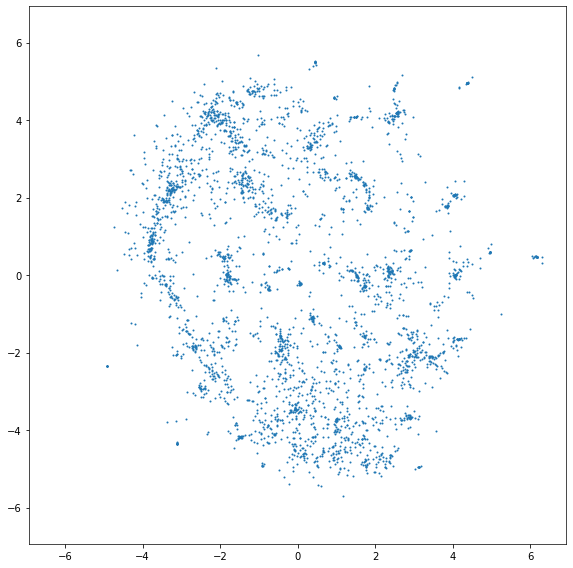

In [77]:
pymde.plot(gwps_viz_variable_embedding)

# Identify clusters (very conservatively) using HDBSCAN

In [82]:
from hdbscan import HDBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

def hdbscan_clusters(target, metric='euclidean', min_cluster_size=5, min_samples=5, cluster_selection_method='leaf', alpha=1.):
    clusterer = HDBSCAN(metric=metric,
                        min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        cluster_selection_method=cluster_selection_method,
                        alpha=alpha)
    clusterer.fit(target)
    clusters = pd.Series(clusterer.labels_, index=target.index)
    return clusters

In [84]:
clusters = hdbscan_clusters(gwps_variable_distances,
                                metric='precomputed',
                                min_cluster_size=5,
                                min_samples=1,
                                cluster_selection_method='leaf')

In [86]:
clusters.value_counts()

-1     2876
 20      22
 14      22
 23      21
 6       16
 19      15
 22      14
 12      13
 13      13
 30      12
 17      12
 10      12
 24      12
 31      11
 27      11
 35       9
 15       9
 16       9
 32       8
 34       8
 29       8
 8        8
 25       8
 3        8
 0        7
 7        7
 2        7
 1        7
 4        6
 28       5
 9        5
 5        5
 11       5
 18       5
 21       5
 33       5
 26       5
dtype: int64

# Check for clusters that have common seed regions and plot an example

In [88]:
import pandas as pd

def find_common_suffix(sequences, threshold=0.9, min_suffix_length=3):
    min_length = min(len(seq) for seq in sequences)
    for i in range(min_length, min_suffix_length - 1, -1):
        suffix = sequences[0][-i:]
        if sum(seq.endswith(suffix) for seq in sequences) >= len(sequences) * threshold:
            return suffix
    return ""

cluster_suffixes = {}
for cluster_id in clusters.unique():
    if cluster_id != -1:
        cluster_sequences = clusters[clusters == cluster_id].index
        common_suffix = find_common_suffix(cluster_sequences)
        if common_suffix:
            cluster_suffixes[cluster_id] = common_suffix

print("Cluster Suffixes:")
for cluster_id, suffix in cluster_suffixes.items():
    print(f"Cluster {cluster_id}: {suffix}")

Cluster Suffixes:
Cluster 23: GAGAG
Cluster 13: GAGG
Cluster 24: GGGG
Cluster 31: CAGAG
Cluster 10: AAGGG
Cluster 14: GGGAG
Cluster 20: GGAG
Cluster 6: GAGGG
Cluster 21: ATGAG
Cluster 9: AGCGG
Cluster 12: TCCCG
Cluster 18: AAGGGG
Cluster 32: CGAG
Cluster 29: CCG
Cluster 11: ACCCGG
Cluster 5: GGCGG
Cluster 1: GAGTG
Cluster 3: CAC
Cluster 22: GGGGA
Cluster 25: GGG
Cluster 28: CCT
Cluster 26: CTG


In [89]:
table['cluster'] = clusters

In [90]:
table['suffix'] = table['cluster'].map(lambda x: cluster_suffixes.get(x, ''))

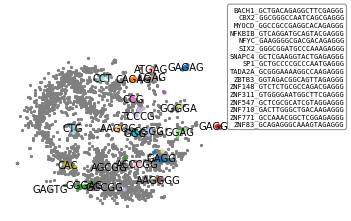

In [103]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(4, 3))

# Plot all points as gray dots
ax.scatter(table['x'], table['y'], color='gray', label='Unclustered', s=5)

# Get the unique cluster labels (excluding -1) that have a suffix
cluster_labels = table[table['suffix'] != '']['cluster'].unique()

# Assign colors to each cluster with a suffix
colors = plt.cm.get_cmap('tab20', len(cluster_labels))

# Plot the clustered points with a suffix and annotate the clusters
for i, cluster_label in enumerate(cluster_labels):
    cluster_points = table[(table['cluster'] == cluster_label) & (table['suffix'] != '')]
    ax.scatter(cluster_points['x'], cluster_points['y'], color=colors(i), label=f'Cluster {cluster_label}', s=10)
    
    # Calculate the center of the cluster
    center_x = cluster_points['x'].mean()
    center_y = cluster_points['y'].mean()
    
    # Get the suffix for the cluster
    suffix = cluster_points['suffix'].iloc[0]
    
    # Annotate the cluster with the suffix
    ax.annotate(suffix, (center_x, center_y), fontsize=10, ha='center', va='center')
    
    # Annotate the cluster with the indices if the suffix is "GAGGG"
    if suffix == "GAGGG":
        indices = cluster_points.index.tolist()
        indices_text = '\n'.join(str(index) for index in indices)
        
        # Create a text box with the indices
        bbox_props = dict(boxstyle="round", fc="white", ec="gray", alpha=0.9)
        ax.text(center_x + 7, center_y, f"{indices_text}", fontsize=7, bbox=bbox_props, family='monospace', ha='right')

# Set the axis labels and titl
# Add a legend
#ax.legend()
ax.axis('off')

# Display the plot
#plt.tight_layout()
plt.savefig('20240405_seed_embedding.pdf', bbox_inches='tight')
plt.show()
